<a href="https://colab.research.google.com/github/alirezasakhaei/SPML_Course2023_Homeworks/blob/main/HW04/UAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPML HW3 - Universal Adversarial Perturbation (30)

### Deadline: 1402/2/30

#### Name: Alireza Sakhaeirad
#### Student No.: 9810174

**Initial Setups** 

In [5]:
from google.colab import drive
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from typing import Type
import numpy as np

# Please use CUDA

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
  print(torch.cuda.get_device_name(0))

#Let's try Drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
# !mkdir ./myCIFAR10



cuda
Tesla T4
Mounted at /content/drive
/content/drive/MyDrive


**Installing & Importing torchattacks for deepfool**

In [ ]:
"""
Deepfool attack is used in UAP algorithm
We suggest to use torchattacks library and its implemented DeepFool
"""

!pip install git+https://github.com/Harry24k/adversarial-attacks-pytorch.git

import torchattacks


**[1] Projection function**

In [22]:
#In this function you wil implement projection due to the given norm (p) 
#For now, only p = 2 and p = Inf is needed to be supported by your function
#Project on the lp ball centered at 0 and of radius e

def proj_lp(v, e, p):
    v = np.array(v)
    if p == 2:
        #Your code goes here
        norm = np.linalg.norm(v)
        v = v * e / norm
    elif p == np.inf:
        #Your code goes here
        norm = np.max(v)
        v = v * e / norm
    else:
         raise ValueError('Values of p different from 2 and Inf are currently not supported!')
    return v

**[2] UAP generation**

In [53]:
#In this function you will implement UAP algorithm for generating a universal perturbation based on the given dataset and model
def clamp_zero_one(image):
    return torch.clamp(image, min=0, max=1)


def calc_fooling_rate(model, dataloader, v):

    total = 0
    fooled = 0
    v = v.to(device)
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images + v)
        _, pred_labels = torch.max(preds.data, 1)
        

        total += labels.shape[0]
        fooled += (labels != pred_labels).sum().item()
    
    return fooled /total



def universal_pert(dataset, model, delta=0.1, max_iter_uni = 99999, eps=10, p=np.inf, num_classes=10, df_overshoot=0.02, df_steps=10):
    '''
    :param dataset: Pytorch Dataset
    :param model: Model to be fooled by the adversarial examples
    :param delta: 1-delta represents the fooling_rate, and the objective (default = 90% fooling rate)
    :param max_iter_uni: Maximum number of iterations of the main algorithm
    :param eps: Controls the l_p magnitude of the perturbation (default = 10)
    :param p: Only p==2 or p==infinity are supported
    :param num_classes: Number of classes on the dataset
    :param df_overshoot: Parameter to the Deep_fool algorithm
    :param df_steps: Maximum iterations of the deep fool algorithm
    :return: perturbation found (and also fooling_rates for iterations and number of total_iterations)
    '''

    model.eval()

    # Initializing the perturbation to 0s
    v = 0#your code goes here
    deepfool = torchattacks.DeepFool(model, steps=df_steps, overshoot=df_overshoot)


    #Initializing fooling rate and iteration count
    fooling_rate = 0.0
    iter = 0
    
    fooling_rates=[]
    total_iterations = []

    """
    Begin of the main loop on Universal Adversarial Perturbations algorithm
    (Provide the conditions due to given delta and maximum number of iterations)
    """
    while (iter < max_iter_uni) and (fooling_rate < (1-delta)): #your code goes here:
        print ('Starting pass number ', iter)

        # Go through the trainset and compute the perturbation increments sequentially
        print(len(dataset))
        for i, data in enumerate(dataset):
            
            image, label = data
            image = image.reshape([1,3,32,32]).to(device)
            
            #Complete the code due to the UAP algorithm
            #your code goes here
            label = torch.tensor(label, dtype = torch.long).reshape([1, 1]).to(device)
            _, pred = torch.max(model(clamp_zero_one(image+v)).data, 1)
            if pred.item() == label:#your code goes here:
                  print('>> k = ', i, ', iter #', iter)
                  
                  #Finding a new minimal perturbation with deepfool to fool the network on this image
                  #your code goes here
                  DELTA = deepfool(clamp_zero_one(image + v), label)
                  #Update v appropriately
                  #your code goes here
                  v_temp = v + DELTA
                  v = proj_lp(v_temp.cpu(), eps, p)
                  v = torch.tensor(v).to(device)
   
        iter = iter + 1

        with torch.no_grad():
            batch_size = 128
            dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = False, num_workers = 2)#your code goes here

            # total = 0
            # fooled = 0

            """Calculate fooling rate
            (Go through the dataset and check that v can fool the model or not. Calculate the ratio of fooled samples to total number of samples.)
            
            #your code goes here
            
            """
            #######
            fooling_rate = calc_fooling_rate(model, dataloader, v)
            #######
            torch.cuda.empty_cache()

            print("FOOLING RATE: ", fooling_rate)
            fooling_rates.append(fooling_rate)
            total_iterations.append(iter)

        print(fooling_rate)
        print(delta)
        print(iter)


    return v, fooling_rates, total_iterations




**Loading CIFAR10**

In [10]:
%cd UAP

/content/drive/MyDrive/UAP


In [11]:
!ls

cifar-10-batches-py	__pycache__  SPML_HW4_UAP_resnet18_cifar10_model_std
cifar-10-python.tar.gz	resnet.py    UAP.ipynb


In [12]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

cifar_trainset = torchvision.datasets.CIFAR10(root='./', train = True, download = False, transform = transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

cifar_testset = torchvision.datasets.CIFAR10(root='./', train = False, download = False, transform = transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size = batch_size, shuffle = False, num_workers = 2)


**[3]Loading model**

In [13]:
from resnet import *

model = ResNet18()
model = model.to(device)
model.train()

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


#Load model state dict using the given saved model (The model is trained with CIFAR10 trainset)
#your code goes here
path = './SPML_HW4_UAP_resnet18_cifar10_model_std'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

**Generate universal perturbation for CIFAR10 using your function**

In [17]:
#First, split the cifar testset into two distinct dataset (Note that number of samples from each class is balanced in these two dataset.)
#UAP_dataset: 50% of testset for using in your UAP algorithm
#evaluation_dataset: 50% of testset for final evaluation of UAP function (Calculating fooling rates of universal v over unseen cifar test samples)
#Then, use your UAP function for generating universal perturbation

"""
UAP_dataset, evaluation_dataset = #your code goes here
"""
# Define a function to split the test set into two balanced datasets
def split_dataset(dataset):
    num_samples = len(dataset)
    num_samples_per_class = num_samples // 10
    labels = [x[1] for x in dataset]
    indices_1 = []
    indices_2 = []

    for i in range(10):
        num_samples_per_class_1 = num_samples_per_class // 2
        num_samples_per_class_2 = num_samples_per_class - num_samples_per_class_1
        indices = [j for j in range(num_samples) if labels[j] == i]
        indices_1 += indices[:num_samples_per_class_1]
        indices_2 += indices[num_samples_per_class_1:num_samples_per_class_1+num_samples_per_class_2]

    dataset_1 = torch.utils.data.Subset(dataset, indices_1)
    dataset_2 = torch.utils.data.Subset(dataset, indices_2)
    return dataset_1, dataset_2

# Split the test set into two balanced datasets
UAP_dataset, evaluation_dataset = split_dataset(cifar_testset)

In [35]:
len(UAP_dataset)

5000

In [ ]:
v, fooling_rates, total_iterations = universal_pert(UAP_dataset, model)

In [67]:
def test(model, loader, T=1, device=device, v = 0):
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    corrects = 0
    total = 0
    # Disable gradient computation for efficiency
    with torch.no_grad():
        for data in loader:
            # Get inputs and labels from the dataloader
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass through the network
            outputs = model(inputs+v)
            
            # Get the predicted class with the highest score
            _, predicted = torch.max(outputs.data, 1)

            # Count how many predictions were correct
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy as the percentage of correct predictions
    accuracy = 100 * correct / total
    return accuracy
    ################################ End #########################################

In [68]:
std_acc = test(model, cifar_testloader, v=0)
adv_acc = test(model, cifar_testloader, v=v)

print(f'Standard Accuracy of the model is {std_acc}')
print(f'Advaersarial Accuracy of the model is {adv_acc}')

Standard Accuracy of the model is 76.78
Advaersarial Accuracy of the model is 10.0


**[4] Plot fooling rates over iterations in UAP**



Note: One iteration was enough for convergence of the universal attack, so plotting isn't going to give any information.  

<StemContainer object of 3 artists>

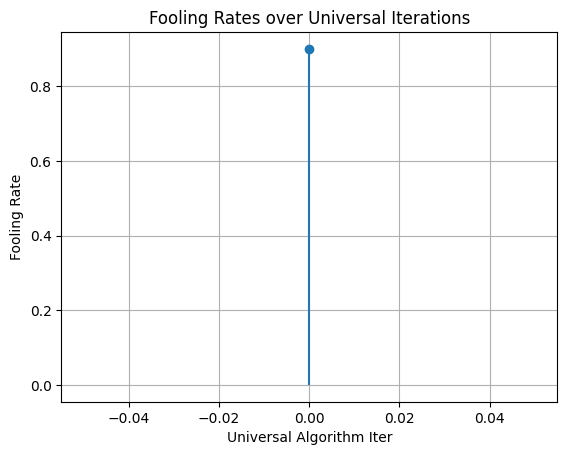

In [69]:
import matplotlib.pyplot as plt

plt.title("Fooling Rates over Universal Iterations")
plt.xlabel("Universal Algorithm Iter")
plt.ylabel("Fooling Rate")
plt.grid(True)
"""
your code goes here
"""
plt.stem(fooling_rates)


**[6] Evaluate fooling rate of universal v on testset**

In [74]:
def test(model, loader, T=1, device=device, v = 0):
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    corrects = 0
    total = 0
    # Disable gradient computation for efficiency
    with torch.no_grad():
        for data in loader:
            # Get inputs and labels from the dataloader
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass through the network
            outputs = model(inputs+v)
            
            # Get the predicted class with the highest score
            _, predicted = torch.max(outputs.data, 1)

            # Count how many predictions were correct
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy as the percentage of correct predictions
    accuracy = 100 * correct / total
    return accuracy
    ################################ End #########################################

In [76]:
#In this section, you will calculate the ratio of fooled samples to total number of samples over unseen test samples


#check the robustness of model on perturbed test samples with your universal perturbation (output of your algorithm on previous sections)
"""
    your code goes here
"""
loader = torch.utils.data.DataLoader(evaluation_dataset, batch_size = batch_size, shuffle = False, num_workers = 2)
evaluation_fooling_rate = 1 - test(model, loader, v = v) / 100
print(evaluation_fooling_rate)

0.9
